[ASKW-13144](https://akridata.atlassian.net/browse/AKSW-13144)

This notebook provides the below mentioned functionalities:
1. Comparsion of different TF-Hub image featurizers and traditional CV featurizer based on compute-time and KNN score accuracy.
2. This notebook also provides a sample dataset to check the different featurizers.

# Initialising Repository

In [ ]:
# This code is to be executed only when the runtime is created for the first time.
!git clone https://github.com/akridata-ai/DE-image-featurizer.git
%cd DE-image-featurizer  
!git checkout develop
!git init


Cloning into 'DE-image-featurizer'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 174 (delta 65), reused 66 (delta 39), pack-reused 56
Receiving objects: 100% (174/174), 1.12 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/DE-image-featurizer
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
Reinitialized existing Git repository in /content/DE-image-featurizer/.git/


In [ ]:
#Changing the path to the de-image-featurizer directory
import os
path = os.path.abspath(os.path.join(os.getcwd(), 'DE-image-featurizer'))
os.chdir(path)

# Importing Libraries

In [ ]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
from evaluate.evaluator import ImageFeatureEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output 


# Dictionary of Featurizers

In [ ]:
'''
FEATURIZERS: A dictionary of featurizers containing both legacy and tf-hub based featurizers.
             The values provided of each featurizer follow the sequence:
              1. The key to differentiate each featurizer
              2. The image size
              3. The number of features to be extracted(specific to ORB and SIFT)
              3. The edge and fast threshold specific to ORB featurizer.(Decrease these parameters if orb featurizer gives error) 
'''
FEATURIZERS ={
            'orb':['orb',(224,224),20,10,10],
            'sift':['sift',(224,224),20],
            'hog':['hog',(224,224)],
            'lbp':['lbp',(224,224)],
            'mobile_netV1':['https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5',(224,224)],
            'mobile_netV2_192':['https://tfhub.dev/google/imagenet/mobilenet_v2_100_192/feature_vector/5',(192,192)],
            'mobile_netV2_160':['https://tfhub.dev/google/imagenet/mobilenet_v2_100_160/feature_vector/5',(160,160)],
            'mobile_netV2_96':['https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5',(96,96)],
            'mobile_netV2_128':['https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/5',(128,128)],
            'mobile_netV3_small_224':['https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5',(224,224)],
            'nasnet_mobile':['https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5',(224,224)],
            'BiT':['https://tfhub.dev/google/bit/s-r50x1/1',(224,224)],
            'InceptionV3_inatural':['https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5',(299,299)],
            'EffiV2_imagenet':['https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2',(384,384)],
            'EffiV2_imagenet21k':['https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2',(512,512)]
            }
            


# Comparator Class
1. This class provides the functionality to create a comparator instance which provides compute-time and accuracy scores for different featurizers.

In [ ]:
"""
Comparator class
Provides the compute-time vs. accuracy statistics w.r.t different 
featurizers.

"""
class Comparator:
    '''
    Provides the functionality to compare different image featurizers using KNN accuracy scores.
    1. The dataset is divided into train and test sets.
    2. Features are computed using the featurizer provided.
    3. Comparative analysis is shown on different numbers of reduced dimensions using PCA.

    Parameters
    -------------
    data_dir: string
        The path to the image dataset

    splits: boolean, default=False
        Whether the directory is further divided into train and test folders.

    Attributes
    ----------
    accuracy: A dictionary containing featurizers and
              their accuracy time.
    compute_time: Dictionary containing time spent to evaluate
                  featurizers.
    results: Pandas `DataFrame` object.
                Contains all the statistics w.r.t. to different featurizers
    '''
    def __init__(self,data_dir,splits):
        """
        Constructor for the Comparator class
        """
        self.data_dir = data_dir
        self.splits = splits
    def compute_time_and_accuracy(self):
        '''
        Method to calculate compute-time and accuracy.
        '''
        
        self.compute_time = {}
        self.accuracy = {}
        for model in FEATURIZERS:
            print(f'Evaluating using {model}')
            start = time.process_time()
            if model=='sift':
                evaluator = ImageFeatureEvaluator(self.data_dir,FEATURIZERS[model][0],input_shape=FEATURIZERS[model][1],splits = self.splits,num_features=FEATURIZERS[model][2])
            elif model=='orb':
                evaluator =ImageFeatureEvaluator(self.data_dir,FEATURIZERS[model][0],input_shape=FEATURIZERS[model][1],splits=self.splits,num_features=FEATURIZERS[model][2],edgeThreshold=FEATURIZERS[model][3],fastThreshold=FEATURIZERS[model][4])
            else:
                evaluator = ImageFeatureEvaluator(self.data_dir,FEATURIZERS[model][0],input_shape=FEATURIZERS[model][1],splits = self.splits)
            results = evaluator.evaluate()
            self.compute_time[model] = time.process_time()-start
            self.accuracy[model] = results.Test_Accuracy.max()

    def plotting_func(self):
        '''
        Method to plot the compute-time vs accuracy graph.
        '''

        plt.figure(figsize = (10,10))
        x = self.compute_time.values()
        y = self.accuracy.values()
        z = self.compute_time.keys()
        sns.scatterplot(x=x, y=y,hue=z,style=z,size=z,s=500,palette='bright')
        plt.xlabel("Compute time in seconds")
        plt.ylabel('Accuracy')
        plt.title('Compute time Vs. Accuracy')
        plt.show()

    def evaluate_featurizers(self):
        '''
        Function to calculate the statistics related to different featurizers.
        '''

        self.compute_time_and_accuracy()
        self.results = pd.DataFrame(self.accuracy.items(),columns=['Featurizer','Best_Testing_Accuracy'])

# Data Inputs

   Select the path to the dataset where the training and
    testing set are divided as given below
    
    if splits==False

        ```
        main_directory/
        ......class_a/
        .........a_image1
        .........a_img2
        ......class_b/
        .........b_img1
        .........b_img2
        ```
    else

        ```
        main_directory/
        ....train/
        ......class_a/
        .........a_image1
        .........a_img2
        ......class_b/
        .........b_img1
        .........b_img2
        ....test/
        ......class_a/
        .........a_image1
        .........a_img2
        ......class_b/
        .........b_img1
        .........b_img2
        ```

In [ ]:
# An example dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
#@title Provide the path to the directory containing the training and testing images
DATASET_PATH = data_dir #@param {type:"string"}
#True if directory is further divided into folders
SPLITS = False #@param {type:"boolean"}

#Create the comparator
comparator = Comparator(DATASET_PATH,SPLITS)
comparator.evaluate_featurizers()

clear_output()

print(comparator.results)

                Featurizer  Best_Testing_Accuracy
0                      orb               0.284741
1                     sift               0.301090
2                      hog               0.457766
3                      lbp               0.460490
4             mobile_netV1               0.900545
5         mobile_netV2_192               0.878747
6         mobile_netV2_160               0.882834
7          mobile_netV2_96               0.855586
8         mobile_netV2_128               0.882834
9   mobile_netV3_small_224               0.878747
10           nasnet_mobile               0.817439
11                     BiT               0.905995
12    InceptionV3_inatural               0.941417
13         EffiV2_imagenet               0.900545
14      EffiV2_imagenet21k               0.968665


# Compute-time VS. Accuracy Plot

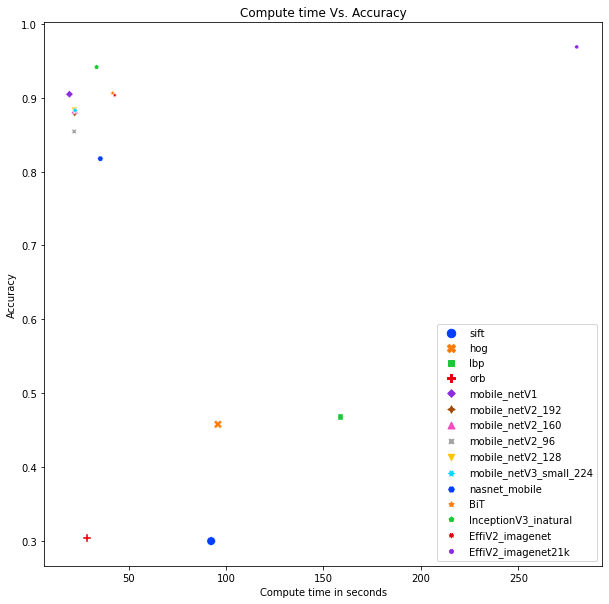

In [ ]:
#Plotting the compute-time Vs accuracy plot
comparator.plotting_func()